# The prisioners dilema

## The Problem

Two detainees, each one has the chance to confess a crime to the police or deny his/her participation in it. 
The police offers a deal and, If both confess the crime, then both get 3 years in prison. If only one talks, then he/she goes free and the other one goes to jail for 5 years. If neither of them confess, then both go to jail for 1 year for minor crime. 

<img src ="Prisioners.PNG" width=400px/>


### The rational agent: 
<b>Must confess.</b> 
This gurantees that the detainee cannot do anything to unilateraly improve his situation. 
If he knows his parter would confess, then he is better of doing the same and going 3 years to prison. If he believes that his partner will not confess, then he is still better off confessing and taking the maxiumum reward. A rational agent will certainly sing without hesitation. 
    
    
### The group equilibrium 
The outcome that ultimately leads to the combined lower number of years in prison is if both do NOT confess. However, there is the temptation to actually betray the other and try to get the maximum reward, which would be "freedom". What would happen in the group as a whole? It is expected that the ultimate result will depend on how tempting is the betrayal and how much it represents a major risk. Technically speaking, both confessing the crime represents more years in jail as a whole than betrayal (6 to 5). If we change the table above and increate the 5 to 10, then the resulting dynamics may be different. 



# Genetic Model

## Genoma 

The genoma is basically a look-up table (key, value). The keys correspond to all the possible histories of three plys that the player can experience. Each of these plys is encoded by six characters in the table. 

<img src="Genome0.png" width = 500px/>

As an example the key CCCCDD will be interpreted as:
       
    C- the player played "C" at time 0          
    C- the opponent playe played "C" at time  0
    C- the player played "C"  at time 1
    C- the opponent played "C" at time 1
    D- the player played "D"  at time 2 
    D- the opponent played played "D" at time 2 
    

In this example, when the player is time for the player to make a move in time t =3, the move will be "D" in accordance to the value of the key="CCCCDD". This means that whenever is the  time for a player to move, it will make a move of either C, or D but the choice is made based on the players experience on previous 3 plys. 

## Player
A player is basically a genoma plus a memory of the last three plays. The memory of six characters will be searched for in the look-up table to decide the next move. As more games are played, the oldest ones are forgotten. Only three games are always remembered.


## Rewards and fitness

The rewards table quoted above is indeed a "Negative rewards table". The higher the number, the worst (more years in jain). We would argue that the most fit individuals, will have a genome that on average, after  playing many games, would lead to less years in prison. Hence, it is the opposite of the table quoted above. 


## Selection 

For every parent pair (p1,p2), one childn is generated. The $ith$ playe is selected accoring to a probaility distribution $P(i)$ where:

$$ \sum_i{ P(i)} = 1 $$

and $P(i)\propto f(i),$ being $f(i)$ the fitness of player $i.$ Note that each parent can be selected multiple times and pairs (p1,p2) where p1=p2 are accepted




### Implementation 

In [12]:
import random
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

from collections import deque, Counter 

random.seed( 42 )

In [52]:
import random
from collections import deque, Counter
random.seed( 42 )


# just returns some pre-configured look-up tables
class GenomaFactory:

    #plays D almost always
    @staticmethod
    def selfish_genoma():
        g = GenomaFactory.get_default()
        for key in g: g[key] = "C" if random.uniform(0.0,1.0)>0.8 else "D"
        return g.copy()
    
    #plays C(cooperate) almost always
    @staticmethod
    def cooperative_genoma():
        g = GenomaFactory.get_default()
        for key in g: g[key] = "D" if random.uniform(0.0,1.0)>0.8 else "C"
        return g.copy()
    
    @staticmethod
    def random_genoma():
        g = GenomaFactory.get_default()
        for key in g: g[key] = random.sample(["C", "D"], 1)[0]
        return g.copy()

    #just repeaces the values in the dictionary and returns a new look-up table. 
    @staticmethod
    def get_from_fenotype(fenotype):
        g = GenomaFactory.get_default()
        count = 0;
        for key in g:
            g[key] = fenotype[count]
            count += 1;

        return g.copy();

    #well.....a default look-up table -useful for debugging-
    @staticmethod
    def get_default():
        # me,other,me,other,me,other ->what will I do? D or C ?
        genome = {
            "CCCCCC": "C", "DCCCCC": "D", "CCCCCD": "D", "DCCCCD": "C", "CCCCDC": "D",
            "DCCCDC": "D", "CCCCDD": "D", "DCCCDD": "D", "CCCDCC": "C", "DCCDCC": "C",
            "CCCDCD": "C", "DCCDCD": "C", "CCCDDC": "C", "DCCDDC": "D", "CCCDDD": "D",
            "DCCDDD": "D", "CCDCCC": "C", "DCDCCC": "D", "CCDCCD": "D", "DCDCCD": "C",
            "CCDCDC": "D", "DCDCDC": "C", "CCDCDD": "D", "DCDCDD": "C", "CCDDCC": "D",
            "DCDDCC": "C", "CCDDCD": "D", "DCDDCD": "D", "CCDDDC": "C", "DCDDDC": "D",
            "CCDDDD": "C", "DCDDDD": "C", "CDCCCC": "C", "DDCCCC": "C", "CDCCCD": "C",
            "DDCCCD": "D", "CDCCDC": "D", "DDCCDC": "C", "CDCCDD": "C", "DDCCDD": "C",
            "CDCDCC": "C", "DDCDCC": "C", "CDCDCD": "D", "DDCDCD": "C", "CDCDDC": "D",
            "DDCDDC": "D", "CDCDDD": "C", "DDCDDD": "D", "CDDCCC": "C", "DDDCCC": "C",
            "CDDCCD": "C", "DDDCCD": "C", "CDDCDC": "D", "DDDCDC": "D", "CDDCDD": "C",
            "DDDCDD": "D", "CDDDCC": "D", "DDDDCC": "C", "CDDDCD": "C", "DDDDCD": "C",
            "CDDDDC": "C", "DDDDDC": "D", "CDDDDD": "D", "DDDDDD": "C"
        };

        return genome.copy();


# the player is basically, a look-up table and a memory of the last moves.
class Player:

    def __init__(self, genoma):
        # the look-up
        self.genoma = genoma

        # this gets the number of letters in the keys of the look-up table (6 in this case->3 moves)
        memory = len(list(genoma.items())[0][0])  
        
        #as we append moves in the queue, the oldest expire to keep the length = 6  = 3 moves for 
        #the player and whoever plsid with it. 
        self.moves = deque(maxlen=memory) 

        #when the player plays for the first time, he has no memory! so he doesnt know what to play.
        #we provide the player with a memory, which is just one of the all possible games in the look-up table 
        # a random key will be taken as the history of moves when a player starts.
        init_history = list(self.genoma)[int(random.uniform(0, len(self.genoma)))]
        for move in init_history: self.moves.append(move)

    # appends my move, other's move
    # moves at the end of the list are the most recent ones
    def append_ply(self, me, other):
        self.moves.append(me)
        self.moves.append(other)

    # based on history, it plays
    def play(self):
        # search for the pattern in the genome table based on the last 3 moves stored
        #from memory gets the key (CCDDDC for instance) and just looks for it in the table 
        s = "".join(self.moves) 
        return self.genoma[s] #D or C

    #this is just for convenience, returns a list of the moves the 
    #player would do under all possible combinations of three games. 
    @property
    def fenotype(self):
        return list([v for k, v in self.genoma.items()])


class Game:

    def __init__(self, reward_table, players, crossover_rate=0.01, mutation_rate=0.1):

        self.players = players;
        self.crossover_rate = crossover_rate
        self.mutation_rate = mutation_rate
        self.player_plys = len(self.players) * [0]
        self.reward_table = reward_table
        self.years =  len(self.players) * [0]


    @property
    def num_players(self):
        return len(self.players)

    # each player plays against all the others, only once.
    # each player stores in its memory the history of plays
    def play_turn(self):

        # each player plays with all the others only one per generation
        for n1 in range(len(self.players)):

            player1 = self.players[n1]

            for n2 in range(len(self.players)):
                player2 = self.players[n2]

                #if n1 == n2: continue

                m1 = player1.play();
                m2 = player2.play();

                #number of years served in prison 
                self.years[n1]+=self.reward_table[(m1, m2)][0]
                self.years[n2]+=self.reward_table[(m2, m1)][0]

                #counter of the number of games played.
                self.player_plys[n1] += 1
                self.player_plys[n2] += 1

                #update the memory. The first letter is always the player (index =0,2,4)
                #the next one is the opponent (index 1,3,5) in the queue 
                player1.append_ply(m1, m2)
                player2.append_ply(m2, m1)

        
    @property 
    def get_fitness(self):
        #lets first get the average number of years (rewards) per game for each player. 
        #This is not really needed because all players play exactly the same number of games. 
        #yet it is still convenient to work with numbers of the order of one.
        avg_years_per_game = np.array(self.years)/np.array( self.player_plys ) 
        
        #because the reward is negative,we will take the fitness as the inverse of the reward. 
        #this is because the less years in prison, the more fit the individual. If you are the most 
        #lucky one and got zero years in prison after many games, your fitness = 1. If you got 5 years 
        #on average , your fitness is 1/6 (you were always betrayed)
        #the higher the fitness, the less the jail time 
        #fitness = list([ 1.0/(years + 1) for years in avg_years_per_game ])
         
        fitness = list([ years for years in avg_years_per_game ])
         
        return fitness 
    
    # generator of parent pairs (index1, index2), ....
    #this function just returns two indices, one for each parent. These are chosen from the probabilities 
    #array: probs taken as argument. A number of N pair is returned. It is assumed that props ranges in [0,1]
    def get_parent_pairs(self, probs, N):
        def replacement_select_index(probabilities):
            while True:
                n = random.randint(0, len(probabilities) - 1)  # inclusive of ends [a,b]
                if random.uniform(0.0, 1.0) < probabilities[n]: return n;

        pairs = 0
        while pairs < N:
            n1 = replacement_select_index(probs)
            n2 = n1
            while n2 == n1:
                n2 = replacement_select_index(probs)

            pairs += 1
            yield (n1,n2)

    def cross_over_mutation(self):

        # we will put the next generation here
        children = []
        
        #lets get the parents in a list of the type (index1, index2), (index1, index2), .....
        #we will pick them according to their fitness. 
        
        #lets create a probability distribution [p1,p2...] where p1i is in th range [0,1] and 
        #the integral equals 1, thats is (p1+p2+p3....) = 1. Lets make it proportional to the fitness 
        #array of probabilities that is in the range [0,1].  
        fitness = self.get_fitness
        selection_probs = np.array(fitness)/( sum(fitness) ) 

        #for each pair of parents, one kid. His fenotype is this one. 
        new_fenotype = None
        for parents in self.get_parent_pairs(selection_probs, len(self.players)):

            #two parents 
            id1 = parents[0]
            id2 = parents[1]
            
            #allow to reproduce from two identical parents (same parent actually)
            if id1 == id2:  # this is allowed, child identical to the parent
                new_fenotype = self.players[id1].fenotype

            else:
                fenotype1 = self.players[id1].fenotype
                fenotype2 = self.players[id2].fenotype
                new_fenotype = []

                p1 = self.players[id1]
                p2 = self.players[id2]

                player = p1
                fenotype = fenotype1

                #for each gene over which there may be a cross-over
                for n in range(len(fenotype1)):
                    
                    #throw a random in [0,1] and figure out if we need to switch the 
                    #parent to copy the genes from 
                    if random.uniform(0.0, 1.0) < self.crossover_rate:  
                        player = p2 if player == p1 else p2
                        fenotype = fenotype2 if fenotype == fenotype1 else fenotype2

                    #gene of whatever the parent we are copying from 
                    letter = fenotype[n]
                    
                    #evaluate the mutation here too 
                    if random.uniform(0.0, 1.0) < self.mutation_rate:
                        letter = "C" if letter == "D" else "D"

                    #put the letter in the fenotype 
                    #if there is no crossover ever, and neither mutation, everything is copied 
                    #from player = p1 
                    new_fenotype.append(letter)

            # this is the next generation
            child1 = Player(GenomaFactory.get_from_fenotype(new_fenotype))
            children.append(child1)

        self.players = children.copy()


    def play_generations(self, num=None):

        for n in range(num):

            self.player_plys = len(self.players) * [0] #number of games played
            self.years = len(self.players) * [0]       #cummulated years in prison (neg reward)
                    
            self.play_turn() #play each player with everyone else 
            
            self.cross_over_mutation();
           
 



### Processing 

In [79]:


#tracks when they played together CC or DD at times t1, t2....
#this is called after each game 
ccs  = [] 
dds  = [] 
diff = []

cs = []
ds = [] 

rewards = [] #time series of the average number of years in prison.
fitness = [] 

def print_cc_dd():
    va = 0 
    vb = 0
    di = 0.0 
    
    players = game.players
    for p in players:
        moves = p.moves;
        for d in [0,2,4]:
            if moves[d]==moves[d+1]:
                if moves[d]=="C":        #if player played C and tge other one played C
                    va=va+1
                else:
                    vb=vb+1              #or if both played D in the same ply 
                
            else: di+=1; 
                
    #these are just counters of the number of occurences of "CC" or "DD" or "CD,DC"
    #we run this at several times so we store the results in a list (time-based)
    ccs.append( va )
    dds.append( vb )
    diff.append( di )


#keeps track in time on how many C's and D's are on average in all players fenotyope
def print_fenotype():

    players = game.players
    
    c = Counter()   
    for p in players: c.update(  p.fenotype )
        
    print("C count:",c["C"], "D count", c["D"])
    cs.append( c["C"])
    ds.append( c["D"])
    
    
#keeps track of the "kind of games" played. For instance, 12 players may have played the games 
#CCCDDD" (me, iother,me,other...) and 5 may have played "DDDDDD" and so on...
#This is the memory of the players/ 
def print_common_games( ):
    
    #strategies_counter = Counter()
    player_moves_counter = Counter()
    
    players = game.players

    #this is the history of 3 moves for every player, example: CCC, CDD, DDD, etc...
    for p in players:
        l = "".join(p.moves) 
        player_moves_counter.update( [l] )
        
    print( "Most freq. players move seq", player_moves_counter.most_common(212))
  
def process_results():
    
    print_common_games() 
    print_fenotype()
    print_cc_dd()
    
    #rewards.append( sum(game.years)) #total years in prison of all the players together in 1 generation
    
    fit = np.mean(game.get_fitness) #mean of the  array of the fitness of all players. 
    fitness.append( fit )
    rewards.append( fit ) #1/fit - 1)
    #fit = 1/(years + 1) ->(years + 1 )fit = 1-> years = 1/fit -1
    
def plot_results():
    font1 = {'family': 'serif','color':  'red','weight': 'normal','size': 12,}
    font2 = {'family': 'serif','color':  'blue','weight': 'normal','size': 12,}
    font3 = {'family': 'serif','color':  'orange','weight': 'normal','size': 12,}
    
    
    ########## FIGURE 1
    #average years in prison   
    plt.figure(figsize=(12,8))
    plt.plot( rewards  ) 
    plt.title("Years in prison per player in each generation ",fontsize=18)
    plt.ylabel("Prision time (years)",fontsize=18)
    plt.xlabel('Generation',fontsize=18)

    plt.show() 
    
    ############FIGURE 2, 
    k = 1#len(ccs)+len(dds)+len(diff)
    cs11 = np.array(ccs)
    ds11 = np.array(dds)
    plt.figure(figsize=(12,8))
    plt.plot( cs11, label = "CC" )
    plt.title("Fraction of times both played the same move at the same time (CC, 25%, DD 25%)",fontsize=18)
    plt.ylabel("Number of CC ",fontsize=18)
    plt.xlabel('Generation',fontsize=18)
    plt.plot( ds11, label ="DD" )
    plt.legend()
    #plt.plot( diff )
    plt.show() 
    
    
    ################FIGURE 3
    cs1 = np.array(cs)
    ds1 = np.array(ds)
    plt.figure(figsize=(12,8))
    plt.plot( cs1 / ( cs1 + ds1), label="C")
    plt.title("Fraction of Cs and Ds in the combined population fenotype",fontsize=18)
    plt.ylabel("Number of Cs and Ds",fontsize=18)
    plt.xlabel('Generation',fontsize=18)
    plt.plot( ds1 / ( cs1 + ds1), label="D")
    plt.legend()
    plt.show() 

 
    ############FIGURE 4 
    #cs = np.array(cs)
    #ds = np.array(ds)
    #c = [ plt.cm.RdYlBu(i) for i in colors ] 
    c = [ plt.cm.RdYlBu(i) for i in range(len(cs1)) ] 
    plt.figure(figsize=(12,8))
    plt.scatter( x = np.array(rewards), y = cs1/(cs1 + ds1), color = c)
    plt.title("Years in prison (all added) vs likelyhood of finding a C in the fenotype",fontsize=18)
    #plt.text(1.8, 0.75, r'Start (collaborate, dont confess)', fontdict=font1)
    #plt.text(2.3, 0.55, r'Later generations' , fontdict=font2)
    #plt.text(2.8, 0.45, r'Later generations', fontdict=font3)
   
    plt.xlabel("Years in prison per generation",fontsize=18)
    plt.ylabel('Cs/(Cs + Ds) combined population fenotype',fontsize=18)
    #plt.text(2, 0.65, r'$\cos(2 \pi t) \exp(-t)$')
    plt.show() 
        
        
        
    ###########Figure 5 
    plt.figure(figsize=(12,8))
    plt.plot(  np.array(rewards), cs1/(cs1 + ds1)  ) 
    
    

## Experiments 

### Experimen 1

In [99]:
init_num_players = 50
mutation_rate    = 1.0/64.0
crossover_rate   = 1./64.0

#TALK    = D (confess, cooperate with the police, rational agent) 
#SILENCE = C (COOPEATE WITH THE GROUP, )
reward_table = { ("C","C"):(2,2), ("D","C"):(12,0),("C","D"):(0,12), ("D","D"):(1,1)}

#selfish players 
players = [ Player( GenomaFactory.random_genoma())  for n in range(init_num_players) ]
game = Game( reward_table, players, crossover_rate, mutation_rate )


In [100]:
ccs  = [] 
dds  = [] 
diff = []
cs = []
ds = [] 
rewards = [] #time series of the average number of years in prison.
fitness = [] 

In [101]:
for k in range( 50 ):
    game.play_generations(10)
    process_results()


Most freq. players move seq [('DDDCCD', 3), ('DDDDDC', 3), ('DDDCCC', 3), ('CDDDCD', 3), ('CCDDCC', 3), ('DCDDDD', 2), ('DDDDDD', 2), ('CDCDDC', 2), ('DDCCCD', 2), ('CCCCDC', 2), ('DCCCDD', 1), ('CCDCDC', 1), ('DCDCCD', 1), ('CCCDDC', 1), ('DCCDCD', 1), ('CCDDDD', 1), ('DCDDCD', 1), ('CDDCCD', 1), ('CDCDDD', 1), ('CDDDDD', 1), ('CDCCCD', 1), ('DCCDDD', 1), ('DDDCDD', 1), ('CDCDCD', 1), ('DDDDCC', 1), ('CDDCDD', 1), ('DDCCDC', 1), ('DCCDCC', 1), ('DCDCDC', 1), ('CCCDCD', 1), ('CCCDDD', 1), ('DCCDDC', 1), ('DDCDCD', 1), ('CCCCDD', 1), ('CCCDCC', 1)]
C count: 1535 D count 1665
Most freq. players move seq [('DDDDCD', 4), ('CCDCCC', 4), ('CDCDCC', 3), ('CDCCCD', 3), ('DDDCDD', 2), ('DCCCDD', 2), ('CCCDCD', 2), ('CCCCCD', 2), ('DDDDDD', 2), ('CDDDDC', 2), ('CDDCCD', 1), ('CCCDDD', 1), ('DCCDDC', 1), ('DCDCDC', 1), ('CDCCDC', 1), ('DDCCDD', 1), ('DDDDDC', 1), ('CDDDCC', 1), ('CDDCDD', 1), ('DCDDDC', 1), ('DDCCDC', 1), ('DCCDCC', 1), ('CDCDDC', 1), ('DCDDDD', 1), ('CDCDCD', 1), ('CDDDCD', 1), 

Most freq. players move seq [('CDCCDC', 3), ('CDCCCC', 2), ('CDDDDC', 2), ('DCCCCD', 2), ('DDCCDD', 2), ('CCDCDC', 2), ('DDDCCC', 2), ('DCDCDD', 2), ('CDDDCC', 2), ('DDCDCD', 2), ('CDDCDD', 2), ('CDDCCC', 2), ('CCDDDD', 2), ('CDCDCD', 1), ('CCDDCC', 1), ('DCCDCC', 1), ('DDDDDC', 1), ('DDDCCD', 1), ('DCDDCD', 1), ('DCDCCC', 1), ('CCCDDC', 1), ('CDDDDD', 1), ('CDDDCD', 1), ('CCCCDC', 1), ('DDDDDD', 1), ('DDCCCD', 1), ('CCDDDC', 1), ('DDCDDD', 1), ('DDDCDD', 1), ('CCDCCC', 1), ('DCDCDC', 1), ('DCDDDC', 1), ('CDDCCD', 1), ('CCCDCC', 1), ('CCCCCC', 1), ('DCDDDD', 1)]
C count: 1414 D count 1786
Most freq. players move seq [('DCCCDC', 4), ('DCDDDD', 4), ('CCDCDC', 3), ('CCDCDD', 3), ('CCDDDD', 2), ('DDDCCD', 2), ('DCCDCC', 2), ('CDDCCD', 2), ('DCDCDC', 2), ('DCDDCD', 2), ('DCCDDD', 2), ('CDDDCC', 2), ('CCDDCC', 2), ('DDCDCD', 1), ('DCDCCC', 1), ('CDDDCD', 1), ('CDDCCC', 1), ('DDCDDD', 1), ('DDDDDD', 1), ('CCCCDC', 1), ('CCDCCD', 1), ('DDDCDC', 1), ('DDDCDD', 1), ('CDDCDD', 1), ('DDCCCC', 1), 

Most freq. players move seq [('CCDCCC', 4), ('DDDDCC', 3), ('DCCDCD', 3), ('DCDCCC', 2), ('DDCDDC', 2), ('DCDCDD', 2), ('DCCCDC', 2), ('CCDDCD', 2), ('CDDDCC', 2), ('CDCDCD', 1), ('CDDCDC', 1), ('DDDCCC', 1), ('DCCDDC', 1), ('CCDDCC', 1), ('CDDDDD', 1), ('CCDDDC', 1), ('DDCCDD', 1), ('DCCCCC', 1), ('CDDDCD', 1), ('DCDDCC', 1), ('DCCCDD', 1), ('CDCCCD', 1), ('DDDCDC', 1), ('DCDCCD', 1), ('DDDCCD', 1), ('CDCDDD', 1), ('CDCDCC', 1), ('DDCDCC', 1), ('CDCCDD', 1), ('CDCCDC', 1), ('CDDCCC', 1), ('CDDCDD', 1), ('CCCDCD', 1), ('CCDDDD', 1), ('CDCCCC', 1), ('CCCDDD', 1), ('DCDCDC', 1)]
C count: 1404 D count 1796
Most freq. players move seq [('DCDCCC', 2), ('CCDDDC', 2), ('CDDDDD', 2), ('CDCCCD', 2), ('CCCDDC', 2), ('DDCCDD', 2), ('CCDCCD', 2), ('DDDDCC', 2), ('DDCCCC', 2), ('DCCDDD', 2), ('DCCDCC', 2), ('CCDDDD', 2), ('CDCDCD', 1), ('DDCCCD', 1), ('CDCDDD', 1), ('DCDDCD', 1), ('CCCDCC', 1), ('CDCCDC', 1), ('CDDCCD', 1), ('DDDCDD', 1), ('CCDDCD', 1), ('DDDDDC', 1), ('DCDDDC', 1), ('CCCDDD', 1), 

Most freq. players move seq [('CDCDCD', 4), ('DDDDDC', 3), ('DCCCDC', 3), ('DDDCCD', 3), ('CDCDCC', 2), ('CDDCCC', 2), ('DDDDDD', 2), ('CCCDCC', 2), ('CDCCCC', 2), ('DCCCCD', 2), ('DCDCCD', 1), ('CCDCDD', 1), ('CCCDCD', 1), ('CDDDDC', 1), ('CCDDDC', 1), ('DDCCCD', 1), ('CDDDCD', 1), ('DCDDDC', 1), ('DDDCCC', 1), ('CDCCDD', 1), ('CDCDDD', 1), ('DCCCDD', 1), ('DDCDCC', 1), ('DDCCDC', 1), ('DCCDDC', 1), ('CCDCCD', 1), ('CCDCDC', 1), ('CCCCDD', 1), ('DDCCDD', 1), ('DCDDCD', 1), ('DCCDDD', 1), ('CCCDDD', 1), ('CDCDDC', 1), ('CDDCDC', 1), ('CCDDCC', 1)]
C count: 1337 D count 1863
Most freq. players move seq [('CDCDCD', 3), ('CCDDDC', 2), ('DCDCDC', 2), ('CDCCDD', 2), ('DDCCCD', 2), ('DCCCCC', 2), ('DDCCCC', 2), ('DDCCDD', 2), ('DCCDCD', 2), ('CCCCCC', 2), ('CDDCCC', 1), ('DCDCDD', 1), ('DDCDCD', 1), ('CDCDDC', 1), ('CDDCDC', 1), ('CDDDCC', 1), ('DCDDDC', 1), ('CCCCDC', 1), ('CCDCDD', 1), ('DDDCCC', 1), ('DDCDDD', 1), ('DDDCDC', 1), ('CCCDCD', 1), ('CDCCCC', 1), ('DDDDDD', 1), ('DCCCDC', 1), 

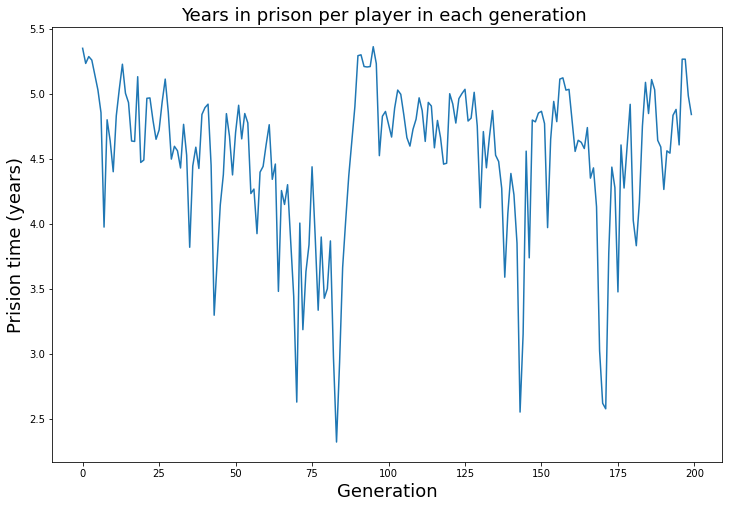

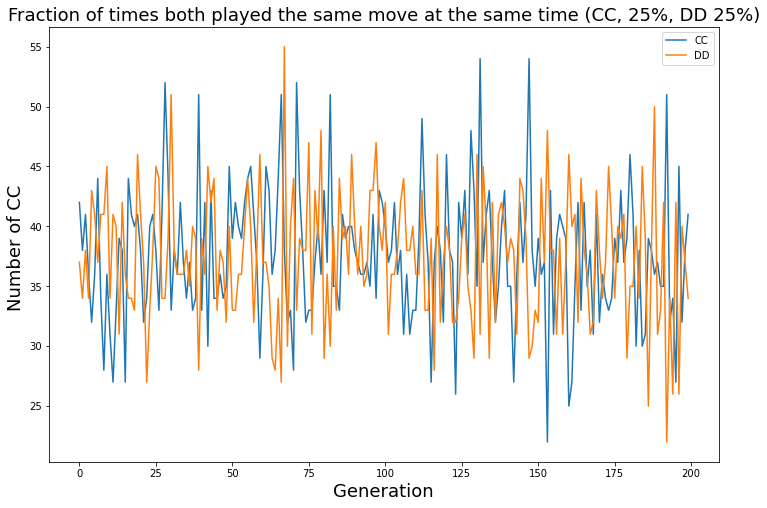

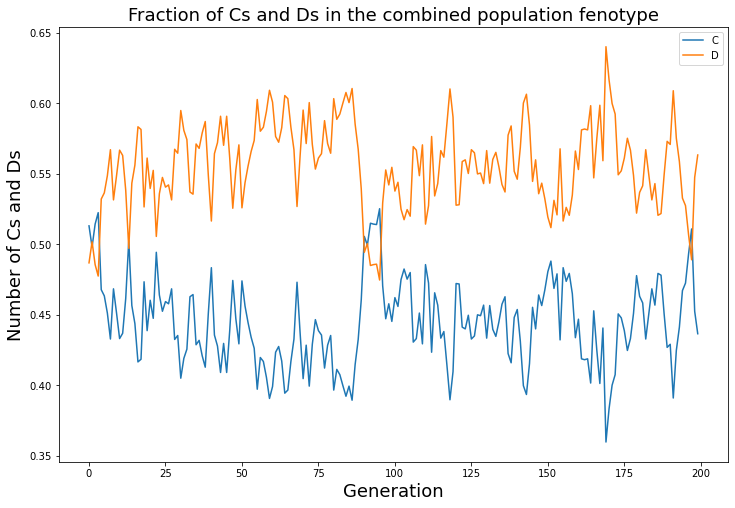

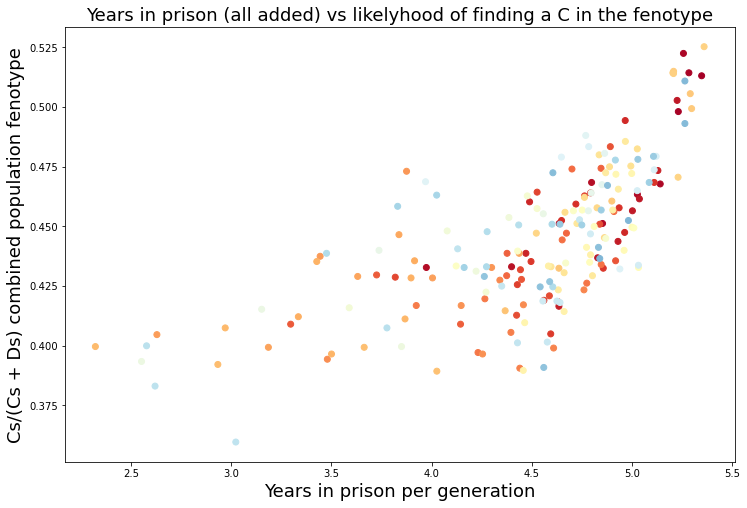

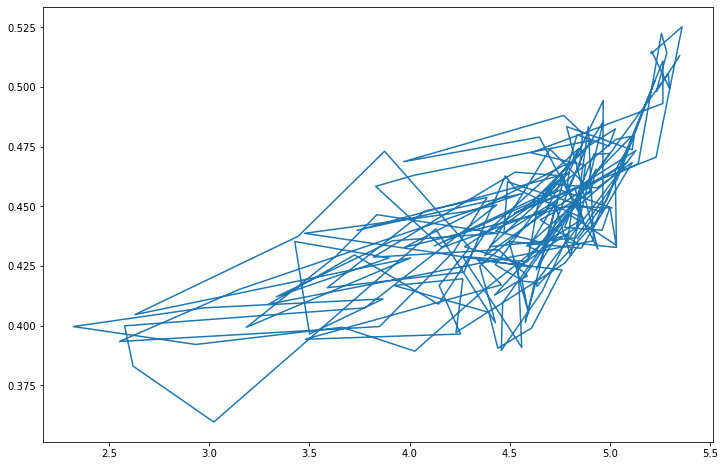

In [98]:
plot_results()

In [71]:
# Red symbols are earlier stages of the game. As the number of generations increases, the colors are colder
# In either case, collaboration CC =(1,1) is benefitial for the group but it is clearly unstable 

# Experiment 2:  Increasing the risk of jail time 

<b> Note that now (C,D) = (15,0) and (D,C) = (0,15)</b>


Keeping quiet is now a tremendous risk of 15 years of jail if the other player confessess. 
The game evolves differently. Now, it is clear, that rationality prevails and the overall outcome is that both confess.
Overall, the average time is about 3 years, which corresponds to an average play of DD (confess,confess). 
Collaboration is long gone now. This is because the fitness function is severely risk-adverse, it goes as 1/years. 
Other models could be different. 


In [412]:
ccs  = [] 
dds  = [] 
diff = []

cs = []
ds = [] 

rewards = [] #time series of the average number of years in prison.
fitness = [] 

#selfish players 
reward_table = { ("D","D"):(3,3), ("D","C"):(0,15),("C","D"):(15,0), ("C","C"):(1,1)}

players = [ Player( GenomaFactory.cooperative_genoma())  for n in range(init_num_players) ]
game = Game( reward_table, players, crossover_rate, mutation_rate )

for k in range( 5 ):
    game.play_generations(1)
    process_results()



Most freq. players move seq [('DCDCCD', 3), ('CDCDDC', 3), ('CCDDCD', 3), ('CDDDDD', 3), ('DDDCCD', 2), ('CDCCDC', 2)]
C count: 2474 D count 726
Most freq. players move seq [('DDDDCD', 3), ('DCDCCD', 2), ('CDCCDC', 2), ('DDDCDD', 2), ('DCCDCC', 2), ('CDDDCC', 2)]
C count: 2464 D count 736
Most freq. players move seq [('CCCDCC', 4), ('DCCCCC', 3), ('DCDDCC', 3), ('DCCCCD', 3), ('DDDCDD', 2), ('CDCDCD', 2)]
C count: 2447 D count 753
Most freq. players move seq [('DDCDDC', 4), ('CCCCDD', 4), ('DCCDCC', 3), ('CCDDDC', 2), ('CDCCCC', 2), ('CDDDCD', 2)]
C count: 2380 D count 820
Most freq. players move seq [('CDCCDC', 3), ('DDDDDC', 3), ('DCDDDC', 3), ('DDDCCC', 2), ('CDDCCC', 2), ('DCCCCD', 2)]
C count: 2350 D count 850


In [407]:
def plot_results():
    font1 = {'family': 'serif','color':  'red','weight': 'normal','size': 12,}
    font2 = {'family': 'serif','color':  'blue','weight': 'normal','size': 12,}
    font3 = {'family': 'serif','color':  'orange','weight': 'normal','size': 12,}
    
    
    ########## FIGURE 1
    #average years in prison   
    plt.figure(figsize=(12,8))
    plt.plot( rewards  ) 
    plt.title("Years in prison per player in each generation ",fontsize=18)
    plt.ylabel("Prision time (years)",fontsize=18)
    plt.xlabel('Generation',fontsize=18)

    plt.show() 
    
    cs1 = np.array(cs)
    ds1 = np.array(ds)
    ############FIGURE 4 
    #cs = np.array(cs)
    #ds = np.array(ds)
    #c = [ plt.cm.RdYlBu(i) for i in colors ] 
    c = [ plt.cm.RdYlBu(i) for i in range(len(cs1)) ] 
    plt.figure(figsize=(12,8))
    plt.scatter( x = np.array(rewards), y = cs1/(cs1 + ds1), color = c)
    plt.title("Years in prison (all added) vs likelyhood of finding a C in the fenotype",fontsize=18)
    plt.xlim(2.5,5.5)
    plt.text(2.8, 0.7, r'Start (collaborate, dont confess)', fontdict=font1)
    plt.text(3.5, 0.5, r'Later generations' , fontdict=font2)
    #plt.text(2.8, 0.45, r'Later generations', fontdict=font3)
   
    plt.xlabel("Years in prison per generation",fontsize=18)
    plt.ylabel('Cs/(Cs + Ds) combined population fenotype',fontsize=18)
    #plt.text(2, 0.65, r'$\cos(2 \pi t) \exp(-t)$')
    plt.show() 
        

### Results

<b> Figure 1 </b>
They now spend 3.x years in prison. This is because now they confess. The risk of collaboration is way to high. 
Keeping quiet may mean 15 years of prison. Since now they often confess (DD), on the average, they spend 
3 years in prison.

<b> Figure 2</b>
The fraction of C's in the genotype has decreased only slightly -they are less likely to collaborate now- but thats 
not the full truth, the number of years in prison tends to three because the most liley 3-game sequences are now different and for those most likely sequences, collaboration is benefitial. If we look at the last sequence printed above, we can 
count more than 26 D's and ony about 13 C's. This is almost a factor of 2. The fenotype still is biased to D's and also the games played are different. If we compare with the previous experiment, it is apparent that there, the games played are 
susbtantially less organized. The number of D's and C's is kind of the same. 



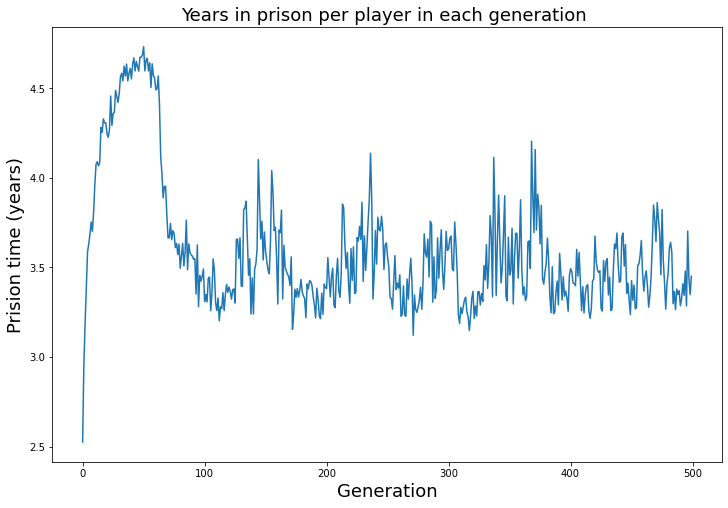

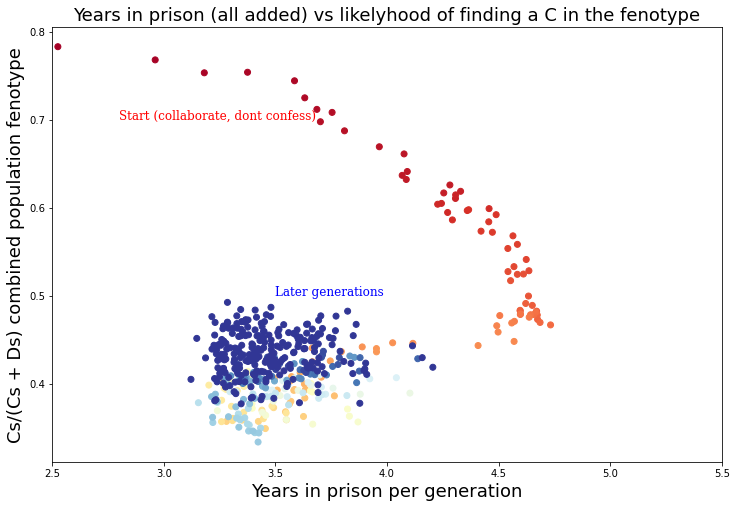

In [409]:
plot_results()

In [ ]:
# Red symbols are earlier stages of the game. As the number of generations increases, the colors are colder